# Lab 13: Clustering

In this lab, we will explore K-Means, Hierarchical Agglomerative, and Spectral Clustering algorithms. Spectral Clustering is out of scope for Spring 2024, but it is included in this lab as a bonus question for your own exploration.

In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab13.ipynb")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# Comment out the following line for more readable exceptions. 
# You may need to restart your server to load the new package after running this cell. 
# %pip install --quiet iwut
# %load_ext iwut
# %wut on

In the first part of this lab, we work with three different toy datasets, all with different clustering characteristics. In the second part, we explore a real-world dataset from the World Bank.

<br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Toy Data 1: Balanced Clusters

Let's begin with a toy dataset with three groups that are completely separated in a 2D space. All groups/clusters have the same number of points, and the variance in all groups is the same.

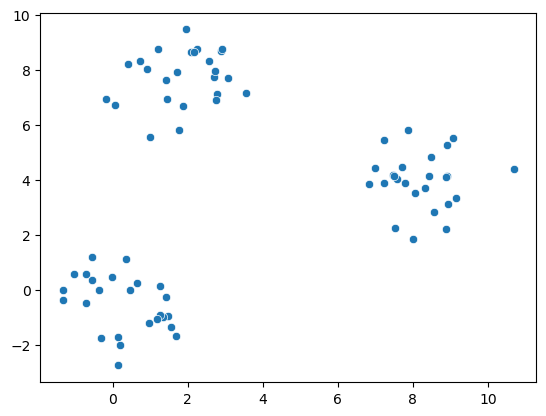

In [4]:
# Run this cell to plot the datapoints.
np.random.seed(1337)

c1 = np.random.normal(size = (25, 2))
c2 = np.array([2, 8]) + np.random.normal(size = (25, 2))
c3 = np.array([8, 4]) + np.random.normal(size = (25, 2))

toy_datapoints_1 = np.vstack((c1, c2, c3))

sns.scatterplot(x = toy_datapoints_1[:, 0], y = toy_datapoints_1[:, 1]);

Below, we create a `cluster.KMeans` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) which implements the K-Means algorithm.

In [5]:
# Plotting K-Means output.

def plot_k_means(data, classifier):
    palette = ['orange', 'brown', 'dodgerblue', 'red']
    sns.scatterplot(x = data[:, 0], y = data[:, 1], 
                hue = classifier.labels_, 
                palette = palette[:classifier.n_clusters])
    sns.scatterplot(x = classifier.cluster_centers_[:, 0], 
                    y = classifier.cluster_centers_[:, 1],
                    color = 'green', marker = 'x', s = 150, linewidth = 3);

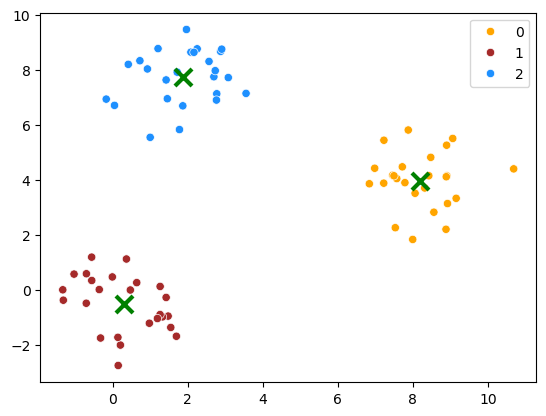

In [6]:
# Run this cell to plot the K-Means cluster.

kmeans = cluster.KMeans(n_clusters = 3, random_state = 42).fit(toy_datapoints_1)
plot_k_means(toy_datapoints_1, kmeans)

We observe that K-Means is able to accurately pick out the three initial clusters. 

<br/>

---

## Question 1: Initial Centers

In the previous example, the K-Means algorithm was able to accurately find the three initial clusters. However, changing the starting centers for K-Means can change the final clusters that K-Means gives us. For this question, we'll initialize the algorithms with `[0, 1]`, `[1, 1]`, and `[2, 2]`. A visualization is shown below: 

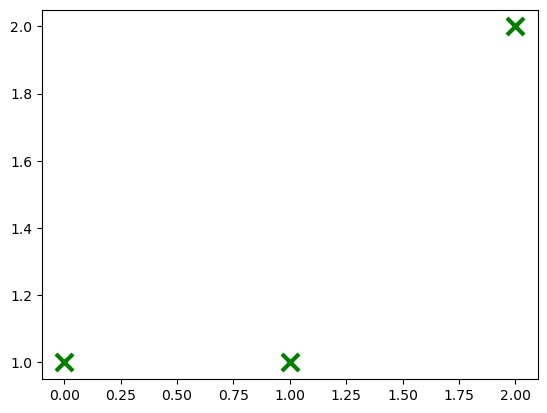

In [7]:
sns.scatterplot(x = [0, 1, 2], 
                y = [1, 1, 2],
                color = 'green', marker = 'x', s = 150, linewidth = 3);

Change the initial centers to the points `[0, 1]`, `[1, 1]`, and `[2, 2]`, and fit a `cluster.KMeans` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) called `kmeans_q1` on the toy dataset from the previous example. Keep the `random_state` parameter as 42, `n_clusters` parameter as 3, and `n_init` as 1.

**Hint:** You will need to change the `init` parameter in `cluster.KMeans`. Read the ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) for more info!

In [8]:
kmeans_q1 = cluster.KMeans(n_clusters = 3, random_state = 42, n_init=1, init=np.array([[0,1],[1,1],[2,2]])).fit(toy_datapoints_1)

In [9]:
grader.check("q1")

q1 results: All test cases passed!

Running the K-Means algorithm with these centers gives us a different result from before, and this particular run of K-Means was unable to accurately find the three initial clusters.

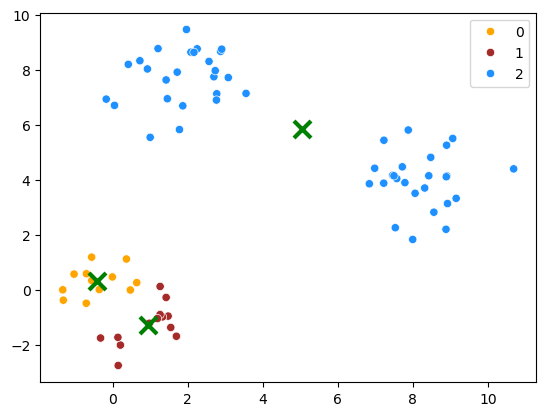

In [10]:
plot_k_means(toy_datapoints_1, kmeans_q1)

<br>

**Note**: Instead of using predetermined centers, one option is to use `init="random"`, and `sklearn` will randomly select initial centers. As shown above, the clustering result varies significantly based on your initial centers. Therefore, `init="random"` is often combined with `n_init` of greater than 1. `sklearn` will then run `n_init` number of times with different randomly initial centers and return the best result. In our case, we are interested in specific initial centers, so we set `n_init=1`.

<br/>

<hr style="border: 1px solid #fdb515;" />

## Toy Data 2: Clusters of Different Sizes

Sometimes, K-Means will have a difficult time finding the "correct" clusters even with ideal starting centers. For example, consider the data below.

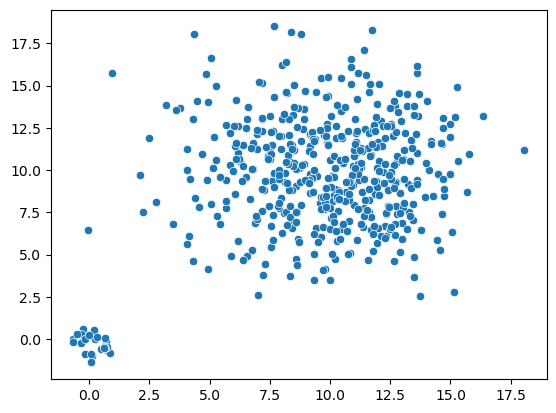

In [11]:
# Run this cell to plot the datapoints.
np.random.seed(1337)

c1 = 0.5 * np.random.normal(size = (25, 2)) 
c2 = np.array([10, 10]) + 3 * np.random.normal(size = (475, 2))
toy_datapoints_2 = np.vstack((c1, c2))
sns.scatterplot(x = toy_datapoints_2[:, 0], y = toy_datapoints_2[:, 1]);

There are two groups of data with different **variability** (i.e., spread) and **number of data points**. The smaller group has both smaller variability and fewer data points, and the larger of the two groups is more diffuse and populated.

<br/>

---

## Question 2a: K-Means

Fit a `cluster.KMeans` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) called `kmeans_q2a` on the dataset above with two clusters and a `random_state` parameter of 42. 

In [12]:
kmeans_q2a = cluster.KMeans(n_clusters= 2, random_state=42, ).fit(toy_datapoints_2)

In [13]:
grader.check("q2a")

q2a results: All test cases passed!

<br/>

As seen below, K-Means is unable to find the two initial clusters on the bottom left and top right. Cluster 1 (in red) is not centered at (0, 0), and it contains points that should belong in the other cluster. Recall that K-Means attempts to minimize inertia, so it makes sense that points near the bottom left of cluster 0 would prefer to be in cluster 1. If these points were in cluster 0 instead, then the resulting cluster assignments would have a larger distortion.

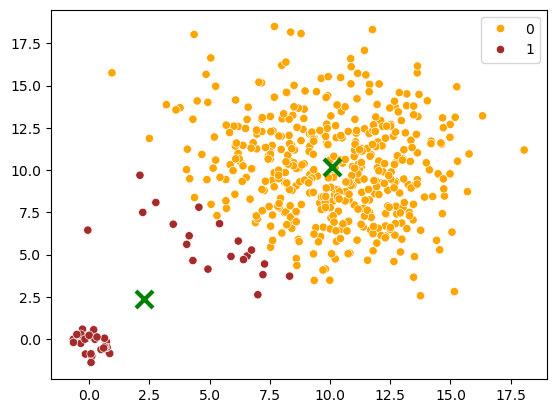

In [14]:
# Run this cell to plot the kmeans cluster.

plot_k_means(toy_datapoints_2, kmeans_q2a)

<br/>

---

## Hierarchical Agglomerative Clustering: The Linkage Criterion

As shown in lecture 27, hierarchical agglomerative clustering works better for this task as long as we choose the right definition of distance between two clusters. Recall that hierarchical clustering starts with every data point in its own cluster and iteratively joins the two closest clusters until there are $k$ clusters remaining. However, the "distance" between the two clusters is ambiguous. 

In the lecture, we used the maximum distance between a point in the first cluster and a point in the second as this notion of distance (Complete Linkage hierarchical clustering), but there are other ways to define the distance between two clusters. 

Our choice of definition for the distance is sometimes called the "linkage criterion." We will discuss three linkage criteria, each of which is a different definition of "distance" between two clusters:

- **Complete linkage** considers the distance between two clusters as the **maximum** distance between a point in the first cluster and a point in the second. 
- **Single linkage** considers the distance between two clusters as the **minimum** distance between a point in the first cluster and a point in the second.
- **Average linkage** considers the distance between two clusters as the **average** distance between points in the first and second clusters.

Below, we fit a `cluster.AgglomerativeClustering` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)) called `agg_complete` on the dataset above with two clusters, using the **complete linkage criterion**.

In [15]:
# Run this cell to fit perform agglomerative clustering on the data.
agg_complete = cluster.AgglomerativeClustering(n_clusters = 2, linkage = 'complete').fit(toy_datapoints_2)

Below, we visualize the results:

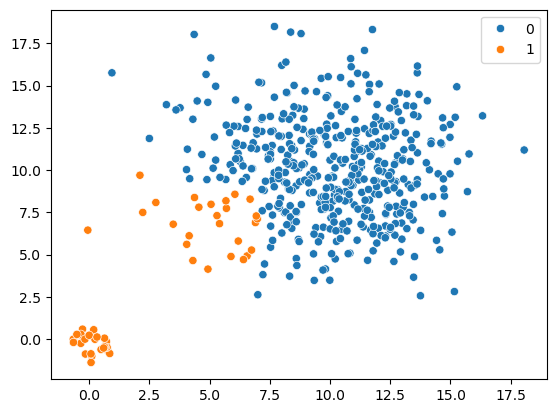

In [16]:
# Run this cell to plot the agglomerative clusters.
sns.scatterplot(x = toy_datapoints_2[:, 0], y = toy_datapoints_2[:, 1], hue = agg_complete.labels_);

It looks like complete linkage agglomerative clustering has the same issue as K-Means! The bottom left cluster found by complete linkage agglomerative clustering includes points from the top right cluster. However, we can remedy this by picking a different linkage criterion.

<br/>

---

## Question 2b: Agglomerative Clustering

Now, use the **single linkage criterion** to fit a `cluster.AgglomerativeClustering` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)) called `agg_single` on the dataset above with two clusters.


In [17]:
agg_single = cluster.AgglomerativeClustering(n_clusters = 2, linkage = 'single').fit(toy_datapoints_2)

In [18]:
grader.check("q2b")

q2b results: All test cases passed!

Finally, we see from the scatterplot on the left that single linkage agglomerative clustering is able to find the two initial clusters. We also plot a dendrogram to visualize the merging hierarchy.

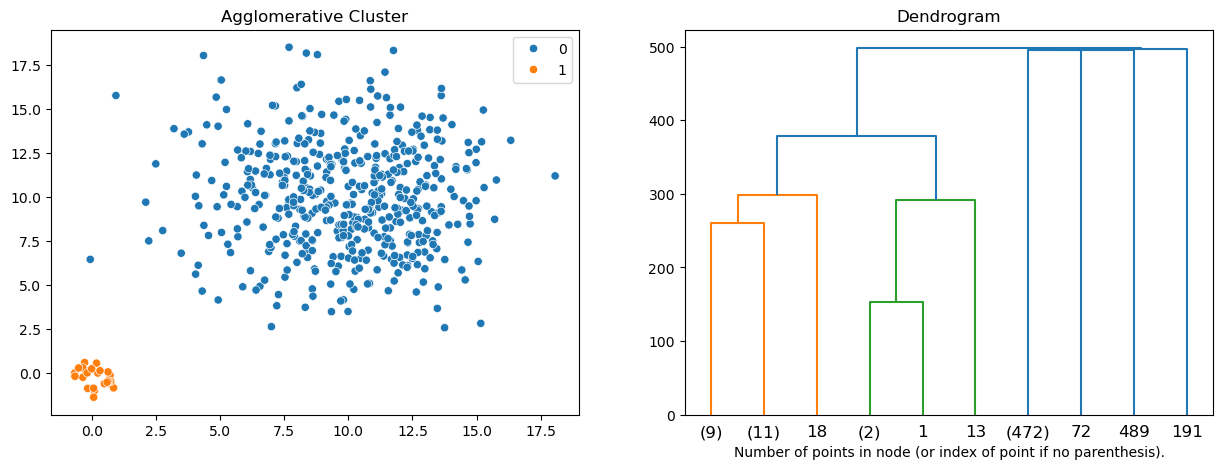

In [19]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    distance = np.arange(model.children_.shape[0])

    linkage_matrix = np.column_stack(
        [model.children_, distance, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Agglomerative Cluster")
sns.scatterplot(x = toy_datapoints_2[:, 0], y = toy_datapoints_2[:, 1], hue = agg_single.labels_);

plt.subplot(122)
plt.title("Dendrogram")
plot_dendrogram(agg_single, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

You might be curious why single linkage "works" while complete linkage does not in this scenario; we will leave this as an exercise for students who are interested.

<br/>

<hr style="border: 1px solid #fdb515;" />

## (Bonus) Toy Data 3: Oddly-Shaped Clusters

(This question is entirely optional)

Another example of when k-means fails is when the clusters have unusual shapes. For example, look at the following dataset.

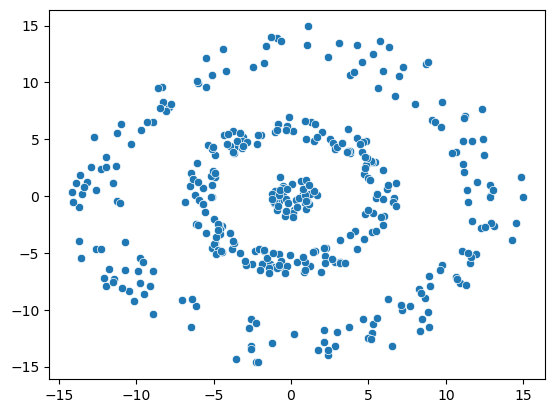

In [20]:
np.random.seed(100)

data = np.random.normal(0, 7, size = (1000, 2))
lengths = np.linalg.norm(data, axis = 1, ord = 2)
toy_datapoints_3 = data[(lengths < 2) | ((lengths > 5) & (lengths < 7)) | ((lengths > 11) & (lengths < 15))]

sns.scatterplot(x = toy_datapoints_3[:, 0], y = toy_datapoints_3[:, 1]);

Looking at this data, we might say there are 3 clusters corresponding to each of the 3 concentric circles, all with the same center. However, k-means will fail.

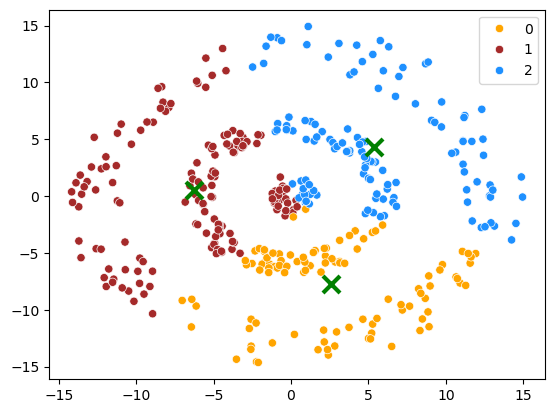

In [21]:
kmeans_q3 = cluster.KMeans(n_clusters = 3, random_state = 42).fit(toy_datapoints_3)
plot_k_means(toy_datapoints_3, kmeans_q3)

<br/>

---

## (Bonus) Question 3: Spectral Clustering

(This question is entirely optional)

(Note in Spring 2024 we did not go over spectral clustering. Spectral clustering is out of scope for exams.) 

Let's try spectral clustering instead. Spectral clustering has roots in graph theory and uses eigenvalues and eigenvectors to determine the connectivity between the data points and cluster them. You can read more about it [here](https://www.geeksforgeeks.org/ml-spectral-clustering/).

In the cell below, create and fit a `cluster.SpectralClustering` object ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)), and assign it to `spectral`. Use 3 clusters, and make sure you set `affinity` to `"nearest_neighbors"` and a `random_state` of 10.


In [22]:
spectral = cluster.SpectralClustering(n_clusters = 3, random_state = 10, affinity = "nearest_neighbors").fit(toy_datapoints_3 )

In [23]:
# Sanity check
sorted(np.unique(spectral.labels_, return_counts = True)[1]) == [42, 170, 174]

True

Below, we see that spectral clustering is able to find the three rings, when k-means does not.

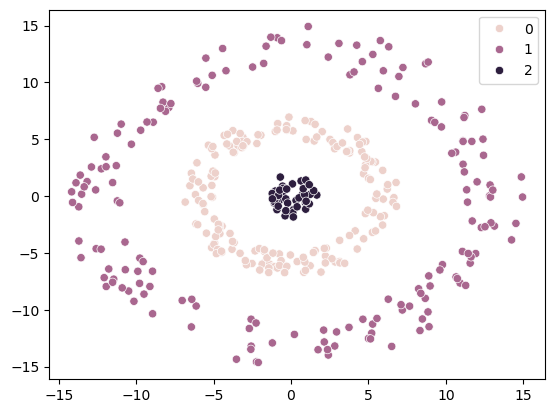

In [24]:
sns.scatterplot(x = toy_datapoints_3[:, 0], y = toy_datapoints_3[:, 1], hue = spectral.labels_);

<br/>

<hr style="border: 1px solid #fdb515;" />

## The World Bank Dataset

In the previous three questions, we looked at clustering on two-dimensional datasets. However, we can easily use clustering on data that have more than two dimensions. For this, let us turn to a [World Bank dataset](https://databank.worldbank.org/source/world-development-indicators) containing various features for the world's countries.

In [25]:
world_bank_data = pd.read_csv("world_bank_data.csv", index_col = 'country')
world_bank_data.head(5)

,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)","Bird species, threatened",Business extent of disclosure index (0=less disclosure to 10=more disclosure),"Contributing family workers, female (% of female employment) (modeled ILO estimate)","Contributing family workers, male (% of male employment) (modeled ILO estimate)","Contributing family workers, total (% of total employment) (modeled ILO estimate)",Cost of business start-up procedures (% of GNI per capita),"Cost of business start-up procedures, female (% of GNI per capita)",...,"Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)",Urban population,Urban population (% of total population),Urban population growth (annual %),"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)"
country,,,,,,,,,,,,,,,,,,,,,
Algeria,57.508032,10.021442,47.486590,15.0,4.0,2.720000,1.836,1.978000,0.0,11.8,...,29.952999,30670086.0,72.629,2.804996,24.337001,27.227001,26.762000,73.734001,68.160004,69.056000
Afghanistan,84.077656,4.758273,79.319383,16.0,8.0,71.780998,9.606,31.577999,0.0,6.4,...,2.639000,9477100.0,25.495,3.350383,95.573997,85.993001,89.378998,4.282000,13.292000,10.108000
Albania,45.810037,20.041214,25.768823,8.0,9.0,37.987000,20.795,28.076000,0.0,11.3,...,30.979000,1728969.0,60.319,1.317162,54.663000,54.994001,54.854000,44.320999,41.542999,42.720001
American Samoa,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,48339.0,87.153,-0.299516,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,67813.0,88.062,-0.092859,NaN,NaN,NaN,NaN,NaN,NaN


There are some missing values. For the sake of convenience and keeping the lab short, we will fill them all with zeros. 

In [26]:
world_bank_data = world_bank_data.fillna(0)

Like with PCA, it sometimes makes sense to center and scale our data so that features with higher variance don't dominate the analysis. For example, without standardization, statistics like population will completely dominate features like `Percent of Total Population that Live in Urban Areas`. This is because the range of populations is on the order of billions, whereas percentages are always between 0 and 100. The ultimate effect is that many of our columns are not really considered by our clustering algorithm.

<br/>

---


## Question 4

Below, fit a `cluster.KMeans` object called `kmeans_q4` with four clusters and a `random_state` parameter of 42.


Make sure you use a centered and scaled version of the World Bank data where the mean in each column should be zero, and the variance should be 1. Assign this centered and scaled data to `world_bank_data_centered_and_scaled`. 

In [27]:

world_bank_data_centered_and_scaled = (world_bank_data - np.mean(world_bank_data, axis = 0))/np.std(world_bank_data, axis = 0)
kmeans_q4 = cluster.KMeans(n_clusters = 4, random_state = 42).fit(world_bank_data_centered_and_scaled)

In [28]:
grader.check("q4")

q4 results: All test cases passed!

Looking at these new clusters, we see that they seem to correspond to:

* 0: Very small countries,
* 1: Developed countries,
* 2: Less developed countries, and
* 3: Huge countries.

In [29]:
# Run this cell to print the clusters.

labeled_world_bank_data_q4 = pd.Series(kmeans_q4.labels_, name = "cluster", index  = world_bank_data.index).to_frame()

for c in range(4):
    print(f">>> Cluster {c}:")
    print(list(labeled_world_bank_data_q4.query(f'cluster == {c}').index))
    print()

>>> Cluster 0:
['American Samoa', 'Andorra', 'Aruba', 'Bermuda', 'British Virgin Islands', 'Cayman Islands', 'Curacao', 'Dominica', 'Faroe Islands', 'Gibraltar', 'Greenland', 'Isle of Man', 'Kosovo', 'Liechtenstein', 'Marshall Islands', 'Monaco', 'Nauru', 'Northern Mariana Islands', 'Palau', 'San Marino', 'Sint Maarten (Dutch part)', 'St. Kitts and Nevis', 'St. Martin (French part)', 'Turks and Caicos Islands', 'Tuvalu']

>>> Cluster 1:
['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Barbados', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Canada', 'Channel Islands', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominican Republic', 'El Salvador', 'Estonia', 'Finland', 'France', 'French Polynesia', 'Georgia', 'Germany', 'Greece', 'Grenada', 'Guam', 'Hong Kong SAR, China', 'Hungary', 'Iceland', 'Iran, Islamic Rep.', 'I

## Silhouette Score

How many clusters $k$ should we use? We can use silhouette score and silhouette plot to determine this. The following code is taken from the documentation [here](https://scikit-learn.org/1.2/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#). Note that we are using an older version of `sklearn` (1.2). The most recent version, `sklearn` 1.4, requires a slightly different code.

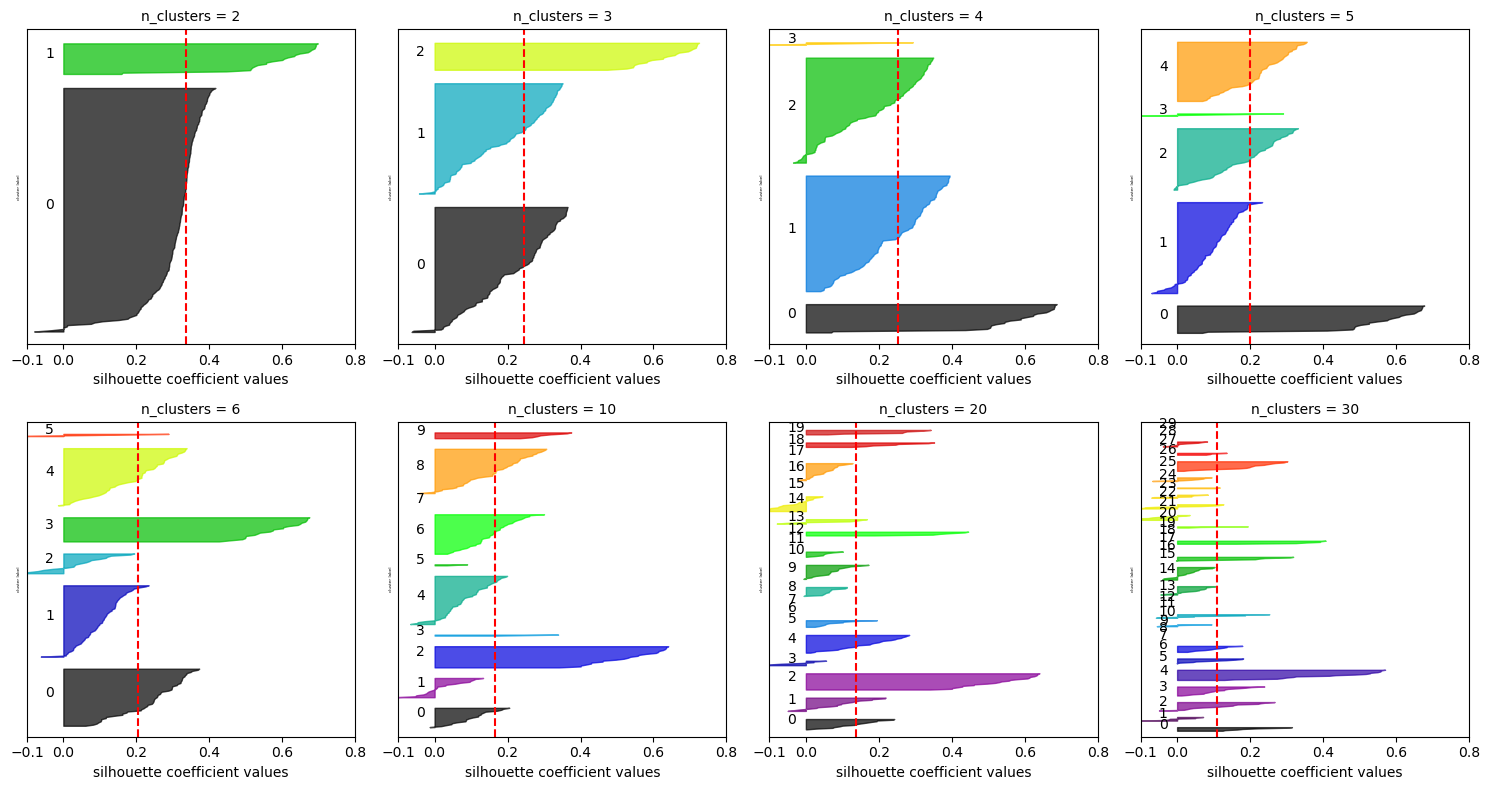

In [30]:
# Run this cell to generate the silhouette plots; no further action required.

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = world_bank_data_centered_and_scaled.to_numpy()
range_n_clusters = [2, 3, 4, 5, 6, 10, 20, 30]
inertia = []

plt.figure(figsize=(15, 8))
for n_clusters in range_n_clusters:
    atoy_datapoints_1 = plt.subplot(2, 4, range_n_clusters.index(n_clusters)+1)
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    atoy_datapoints_1.set_xlim([-0.1, 0.8])
    atoy_datapoints_1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    inertia += [clusterer.inertia_]

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        atoy_datapoints_1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        atoy_datapoints_1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    atoy_datapoints_1.set_title("n_clusters = %d"% n_clusters, fontsize=10)
    atoy_datapoints_1.set_xlabel("silhouette coefficient values", fontsize=10)
    atoy_datapoints_1.set_ylabel("cluster label", fontsize=3)

    # The vertical line for average silhouette score of all the values
    atoy_datapoints_1.axvline(x=silhouette_avg, color="red", linestyle="--")

    atoy_datapoints_1.set_yticks([])  # Clear the yaxis labels / ticks
    atoy_datapoints_1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8])


plt.tight_layout()
plt.show()

<!-- BEGIN QUESTION -->

<br>

---

## Question 5

Based on the plots above how many clusters $k$ would you use and why? There is no single correct answer.

The average silhouette score seems to be tied between 3 and 4 clusters, but 3 is probably optimal for our use case. Adding that fourth (#3) cluster does almost nothing in terms of silhouette score and the figure for 3 has very little mass compared to the figures of 0,1, and 2.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 6

We have saved the inertia generated using different numbers of clusters above in the array `inertia` and used it to construct an elbow plot. Based on the plot, what number of clusters you would choose and why? There is no single correct answer.

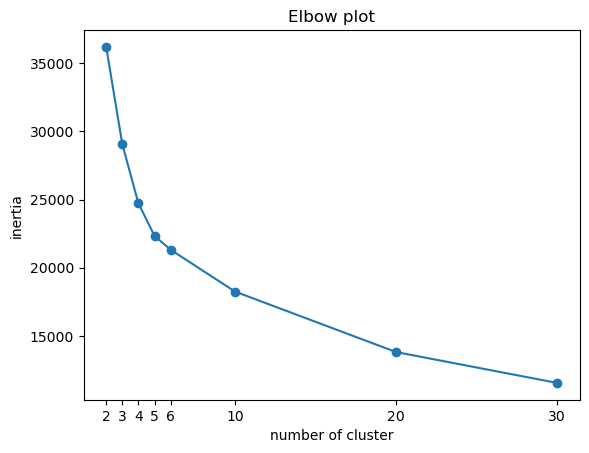

In [31]:
plt.plot(range_n_clusters, inertia)
plt.scatter(range_n_clusters, inertia)
plt.title("Elbow plot")
plt.xlabel("number of cluster")
plt.ylabel("inertia")
plt.xticks(range_n_clusters);

The slope levels off after cluster 6, and the elbow point is quite visible to be around this point. I think we should use 6 clusters here because the intertia captured by points beyond 6 becomes decreasingly impactful, by analyzing the slope of the elbow plot.

<!-- END QUESTION -->

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Perry the Platypus congratulates you for finishing Lab 13!

Here are some pictures from the Data 100 Pets Thread first-place gold medal winner:

<img src='images/perry1.jpeg' width=75px /> <img src='images/perry2.png' width=75px /> <img src='images/perry3.png' width=75px /> <img src='images/perry4.png' width=75px /> <img src='images/perry5.png' width=75px /> <img src='images/perry6.png' width=75px /> <img src='images/perry7.png' width=75px /> <img src='images/perry8.png' width=75px /> <img src='images/perry9.png' width=75px /> <img src='images/perry10.png' width=75px /> <img src='images/perry11.png' width=75px /> <img src='images/perry12.png' width=75px /> <img src='images/perry13.png' width=75px /> <img src='images/perry14.png' width=75px /> <img src='images/perry15.png' width=75px /> <img src='images/perry16.png' width=75px /> <img src='images/perry17.png' width=75px /> <img src='images/perry18.png' width=75px /> <img src='images/perry19.png' width=75px />

Best of luck on the final and your future data science endeavors!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [32]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2a results: All test cases passed!

    q2b results: All test cases passed!

    q4 results: All test cases passed!
